In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x7fc6699294a8>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'date': '2010-01-01',
 'id': 1}

In [10]:
from sqlalchemy import inspect
inspector = inspect(engine)

In [11]:
inspector.get_table_names()

['measurement', 'station']

In [12]:
columns = inspector.get_columns('measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [13]:
# Find the most recent date in the data set.
most_recent = session.query(func.max(Measurement.date)).first()
print(most_recent)

('2017-08-23',)


In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

one_year_ago = dt.datetime.strptime(most_recent[0], '%Y-%m-%d') - dt.timedelta(days = 365)
print(one_year_ago)

2016-08-23 00:00:00


In [15]:
# Perform a query to retrieve the data and precipitation scores

data = session.query(Measurement.date, Measurement.prcp).\
        filter(Measurement.date >= one_year_ago).\
        order_by(Measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

data_df = pd.DataFrame(data).set_index('date')

#see to make sure that we have all the dates that we want
data_df

,prcp
date,
2017-08-23,0.00
2017-08-23,0.00
2017-08-23,0.08
2017-08-23,0.45
2017-08-22,0.00
...,...
2016-08-24,2.28
2016-08-24,NaN
2016-08-24,1.22


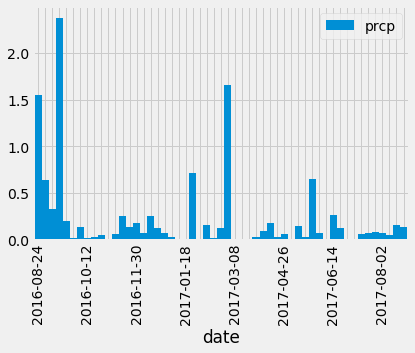

In [16]:
# Use Pandas Plotting with Matplotlib to plot the data

total_rain_df = data_df.groupby('date').mean() #multiple measures per day, taking just the mean

bar = total_rain_df.iloc[::7, :].plot(kind = 'bar',width=1.0) #using only every 7th row or else graph too bunched

date = bar.xaxis.get_ticklabels() #showing only every 7th label
date = list(set(date) - set(date[::7]))
for label in date:
    label.set_visible(False)
    
plt.show()

In [17]:
# Use Pandas to calcualte the summary statistics for the precipitation data
total_rain_df.agg(['mean', 'median', 'min','max','std'])

,prcp
mean,0.169987
median,0.070000
min,0.000000
max,2.380000
std,0.295722


# Exploratory Station Analysis

In [18]:
#inspect columns of the station table
columns = inspector.get_columns('station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [19]:
# Design a query to calculate the total number stations in the dataset
total_stations = session.query(func.count(Station.id)).all()
print(total_stations[0][0])

9


In [20]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(Measurement.station,func.count(Measurement.id)).\
                    group_by(Measurement.station).\
                    order_by(func.count(Measurement.id).desc()).all()

for station in active_stations:
    print(station)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [21]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
stats = session.query(func.min(Measurement.prcp),func.max(Measurement.prcp),func.avg(Measurement.prcp)).\
        filter(Measurement.station == 'USC00519281').all()
print('For Station USC00519281')
print(f'Min Temp: {stats[0][0]}.') 
print(f'Max Temp: {stats[0][1]}.')
print(f'Average Temp {stats[0][2]}.')

For Station USC00519281
Min Temp: 0.0.
Max Temp: 9.64.
Average Temp 0.2123520923520915.


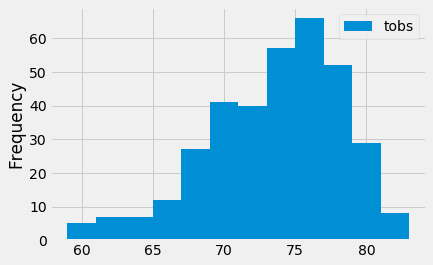

In [22]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

data_active_station = session.query(Measurement.date,Measurement.tobs).\
        filter(Measurement.station == 'USC00519281').\
        filter(Measurement.date >= one_year_ago).\
        order_by(Measurement.date.desc()).all()

data_active_station_df = pd.DataFrame(data_active_station)

data_active_station_df.groupby('date').sum().plot.hist(bins = 12)

# Close session

In [23]:
# Close Session
session.close()